### Importation des librairies

In [1]:
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [3]:
import torchvision
import torchvision.transforms

### Transformation du jeu de données MNIST

In [4]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

In [5]:
type(mnist_train)

torchvision.datasets.mnist.MNIST

In [7]:
#d(mnist_train.targets)

In [8]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

### Fonction générale pour l'entraînement des modèles

In [11]:
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

it =  iter(train_loader)
inputs, targets = next(it)

outputs = model(inputs)
loss = criterion(outputs, targets)

In [13]:
def train(model, optimizer, criterion, train_loader, test_loader):

    train_loss, validation_loss = [], []
    train_accuracy, validation_accuracy = [], []
    
    def loss_function(model, data, training):
        losses = []
        for batch_idx, (inputs, targets) in enumerate(data):
            if training:
                optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            if training:
                loss.backward()
                optimizer.step()
                loss = criterion(model(inputs), targets)
            losses.append(loss.data.item())   
        return np.mean(losses)
        
    def accuracy_function(model, data):    
        model.eval()
        total, correct = 0, 0
        accuracy = []
        for batch_idx, (inputs, targets) in enumerate(data):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
        return (100 - int(correct)/int(total) * 100)

    for epoch in range(10):
        train_loss.append(loss_function(model, train_loader, True))
        train_accuracy.append(accuracy_function(model, train_loader))
        print('Epoch: %d \nTrain      Loss : %.3f Error : %.3f' % (epoch+1, train_loss[-1], train_accuracy[-1]))
        
        validation_loss.append(loss_function(model, test_loader, False))
        validation_accuracy.append(accuracy_function(model, test_loader))
        print('VALIDATION Loss : %.3f Error : %.3f' % (validation_loss[-1], validation_accuracy[-1]))
        print('--------------------------------------------------------------')
    
    model.train()
    
    return {'train_loss': train_loss, 'validation_loss': validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy}

### Architecture du réseau convolutif

In [14]:
class CNN(nn.Module):
    """Convnet Classifier"""
    def __init__(self, dropout):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            # Layer 2
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            # Layer 4
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            # Layer 6
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            # Layer 8
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        self.mlp = nn.Sequential(
                nn.Linear(128, 1000),
                nn.ReLU(),
                nn.Linear(1000, 100),
                nn.ReLU(),
                nn.Linear(100, 10)
        )
        
    def forward(self, x):
        return self.mlp(self.conv(x).squeeze())

### Question 3.0 - Entraînement du CNN

In [15]:
cnn = CNN(dropout=0)
optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

train_cnn = train(cnn, optimizer, criterion, train_loader, test_loader)

Epoch: 1 
Train      Loss : 1.188 Error : 5.087
VALIDATION Loss : 0.141 Error : 4.420
--------------------------------------------------------------
Epoch: 2 
Train      Loss : 0.034 Error : 1.848
VALIDATION Loss : 0.059 Error : 1.970
--------------------------------------------------------------
Epoch: 3 
Train      Loss : 0.015 Error : 2.862
VALIDATION Loss : 0.091 Error : 2.870
--------------------------------------------------------------


KeyboardInterrupt: 

Courbes des erreurs de classification sur les ensembles d'entraînement et de validation.

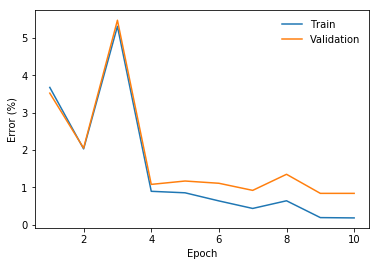

In [9]:
plt.plot(range(1, len(train_cnn['train_accuracy'])+1, 1), train_cnn['train_accuracy'], label='Train')
plt.plot(range(1, len(train_cnn['validation_accuracy'])+1, 1), train_cnn['validation_accuracy'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Error (%)')
leg = plt.legend()
leg.get_frame().set_alpha(0)

### Question 3.2 - CNN vs MLP

### Architecture du MLP

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

Entraînement du MLP.

In [9]:
clf = MLP()
optimizer = torch.optim.SGD(clf.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

train_mlp = train(clf, optimizer, criterion, train_loader, test_loader)

Epoch: 1 
Train      Loss : 0.365 Error : 6.020
VALIDATION Loss : 0.207 Error : 6.000
--------------------------------------------------------------
Epoch: 2 
Train      Loss : 0.101 Error : 4.378
VALIDATION Loss : 0.159 Error : 4.780
--------------------------------------------------------------
Epoch: 3 
Train      Loss : 0.057 Error : 2.422
VALIDATION Loss : 0.102 Error : 3.070
--------------------------------------------------------------
Epoch: 4 
Train      Loss : 0.036 Error : 1.628
VALIDATION Loss : 0.081 Error : 2.530
--------------------------------------------------------------
Epoch: 5 
Train      Loss : 0.024 Error : 1.913
VALIDATION Loss : 0.092 Error : 2.950
--------------------------------------------------------------
Epoch: 6 
Train      Loss : 0.017 Error : 1.220
VALIDATION Loss : 0.074 Error : 2.360
--------------------------------------------------------------
Epoch: 7 
Train      Loss : 0.012 Error : 0.702
VALIDATION Loss : 0.065 Error : 2.000
--------------------

Courbes de l'entropie croisée sur les ensembles d'entraînement et de validation.

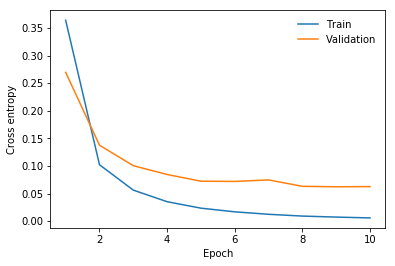

In [12]:
plt.plot(range(1, len(train_mlp['train_loss'])+1, 1), train_mlp['train_loss'], label='Train')
plt.plot(range(1, len(train_mlp['validation_loss'])+1, 1), train_mlp['validation_loss'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
leg = plt.legend()
leg.get_frame().set_alpha(0)

Courbes des erreurs de classification sur les ensembles d'entraînement et de validation.

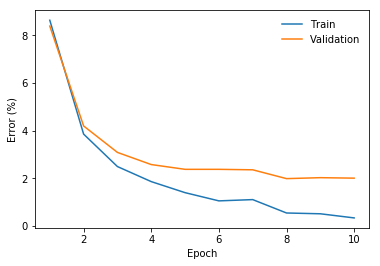

In [13]:
plt.plot(range(1, len(train_mlp['train_accuracy'])+1, 1), train_mlp['train_accuracy'], label='Train')
plt.plot(range(1, len(train_mlp['validation_accuracy'])+1, 1), train_mlp['validation_accuracy'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Error (%)')
leg = plt.legend()
leg.get_frame().set_alpha(0)

Comparaison des performances entre le CNN et le MLP.

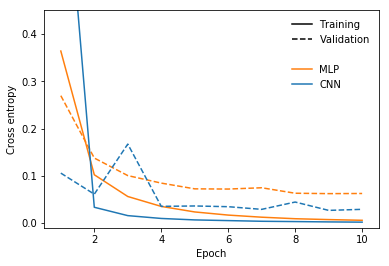

In [14]:
cmap = plt.get_cmap("tab10")

plt.plot([-1] * len(train_mlp['train_loss']), label='Training', color='k')
plt.plot([-1] * len(train_mlp['train_loss']), label='Validation', linestyle='dashed', color='k')
plt.plot([-1] * len(train_mlp['train_loss']), label='     ', linestyle='dashed', color='white')

plt.plot(range(1, len(train_mlp['train_loss'])+1, 1), train_mlp['train_loss'], color=cmap(1), label='MLP')
plt.plot(range(1, len(train_mlp['validation_loss'])+1, 1), train_mlp['validation_loss'], linestyle='dashed', color=cmap(1))

plt.plot(range(1, len(train_mlp['train_loss'])+1, 1), train_cnn['train_loss'], color=cmap(0), label='CNN')
plt.plot(range(1, len(train_mlp['validation_loss'])+1, 1), train_cnn['validation_loss'], linestyle='dashed', color=cmap(0))

plt.ylim(-0.01, .45)
plt.xlim(0.5, 10.5)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
leg = plt.legend()
leg.get_frame().set_alpha(0) 

### Question 3.3 - Régularisation dans un CNN

In [15]:
clf = CNN(dropout=0.5)
optimizer = torch.optim.SGD(clf.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

train_cnn_dropout = train(clf, optimizer, criterion, train_loader, test_loader)

Epoch: 1 
Train      Loss : 0.768 Error : 4.303
VALIDATION Loss : 0.536 Error : 3.960
--------------------------------------------------------------
Epoch: 2 
Train      Loss : 0.034 Error : 2.158
VALIDATION Loss : 0.063 Error : 1.900
--------------------------------------------------------------
Epoch: 3 
Train      Loss : 0.014 Error : 0.902
VALIDATION Loss : 0.032 Error : 0.970
--------------------------------------------------------------
Epoch: 4 
Train      Loss : 0.008 Error : 0.742
VALIDATION Loss : 0.033 Error : 1.170
--------------------------------------------------------------
Epoch: 5 
Train      Loss : 0.005 Error : 1.775
VALIDATION Loss : 0.060 Error : 1.830
--------------------------------------------------------------
Epoch: 6 
Train      Loss : 0.004 Error : 1.420
VALIDATION Loss : 0.050 Error : 1.700
--------------------------------------------------------------
Epoch: 7 
Train      Loss : 0.003 Error : 0.288
VALIDATION Loss : 0.024 Error : 0.790
--------------------

Comparaison des performances basées sur la vraisemblance d'un CNN avec ou sans Dropout.

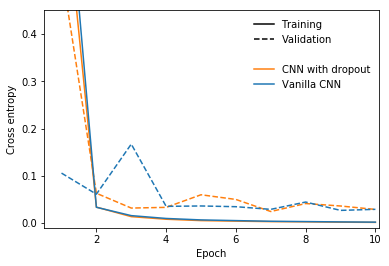

In [21]:
cmap = plt.get_cmap("tab10")

plt.plot([-1] * len(train_mlp['train_loss']), label='Training', color='k')
plt.plot([-1] * len(train_mlp['train_loss']), label='Validation', linestyle='dashed', color='k')
plt.plot([-1] * len(train_mlp['train_loss']), label='     ', linestyle='dashed', color='white')

plt.plot(range(1, len(train_cnn['train_loss'])+1, 1), train_cnn_dropout['train_loss'], color=cmap(1), label='CNN with dropout')
plt.plot(range(1, len(train_cnn['validation_loss'])+1, 1), train_cnn_dropout['validation_loss'], linestyle='dashed', color=cmap(1))

plt.plot(range(1, len(train_cnn['train_loss'])+1, 1), train_cnn['train_loss'], color=cmap(0), label='Vanilla CNN')
plt.plot(range(1, len(train_cnn['validation_loss'])+1, 1), train_cnn['validation_loss'], linestyle='dashed', color=cmap(0))

plt.ylim(-0.01, .45)
plt.xlim(0.5, 10.1)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
leg = plt.legend()
leg.get_frame().set_alpha(0)

Comparaison des performances basées sur l'erreur de classification d'un CNN avec ou sans Dropout.

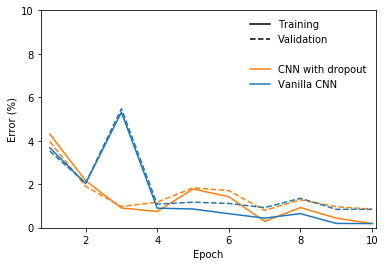

In [20]:
cmap = plt.get_cmap("tab10")

plt.plot([-1] * len(train_mlp['train_loss']), label='Training', color='k')
plt.plot([-1] * len(train_mlp['train_loss']), label='Validation', linestyle='dashed', color='k')
plt.plot([-1] * len(train_mlp['train_loss']), label='     ', linestyle='dashed', color='white')

plt.plot(range(1, len(train_cnn['train_loss'])+1, 1), train_cnn_dropout['train_accuracy'], color=cmap(1), label='CNN with dropout')
plt.plot(range(1, len(train_cnn['validation_loss'])+1, 1), train_cnn_dropout['validation_accuracy'], linestyle='dashed', color=cmap(1))

plt.plot(range(1, len(train_cnn['train_loss'])+1, 1), train_cnn['train_accuracy'], color=cmap(0), label='Vanilla CNN')
plt.plot(range(1, len(train_cnn['validation_loss'])+1, 1), train_cnn['validation_accuracy'], linestyle='dashed', color=cmap(0))

plt.ylim(-0.01, 10)
plt.xlim(0.75, 10.1)
plt.xlabel('Epoch')
plt.ylabel('Error (%)')
leg = plt.legend()
leg.get_frame().set_alpha(0)